In [96]:
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import numpyro.distributions as dist
import pandas as pd
import seaborn as sns
from jax import random
from numpyro.infer import MCMC, NUTS
import jax.numpy as jnp
from scipy.stats import gaussian_kde

In [97]:
# common functions
sigmoid = lambda x: 1 / (1 + jnp.exp(-x))

# Problem 2: Reed Frogs

The common reed frog is a species of frogs found naturally in many parts of Africa. 

In this assignment, we check, evaluate and compare three models which rely on tank density, frog size and predation to predict frog survivability. ![common Reed Frog](https://upload.wikimedia.org/wikipedia/commons/3/36/Tree_frog_congo.jpg)	

In [98]:
df = pd.read_csv('../input/04reedfrogs.csv')


In [99]:
# categorize values
df["cdensity"] = pd.factorize(df.density)[0]
df["cpred"] = pd.factorize(df.pred)[0]
df["csize"] = pd.factorize(df["size"])[0]
df.head(10)

,density,pred,size,surv,propsurv,cdensity,cpred,csize
0,10,no,big,9,0.9,0,0,0
1,10,no,big,10,1.0,0,0,0
2,10,no,big,7,0.7,0,0,0
3,10,no,big,10,1.0,0,0,0
4,10,no,small,9,0.9,0,0,1
5,10,no,small,9,0.9,0,0,1
6,10,no,small,10,1.0,0,0,1
7,10,no,small,9,0.9,0,0,1
8,10,pred,big,4,0.4,0,1,0
9,10,pred,big,9,0.9,0,1,0


## Effect of Predation
It is easily visible that predation has a large effect on the frogs' survivability:

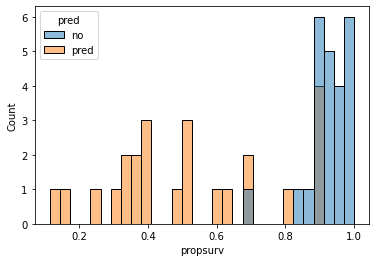

In [100]:
sns.histplot(data=df, x="propsurv", hue="pred", bins=30);

## Defining the Models
`reedfrogs_lin` is the generalized linear regression model. `reedfrogs_hier5` is the hierarchical model from lecture 5 based on population only. `reedfrogs_hier6` is the hierarchical model from lecture 6 based on population size and predation.

In [101]:
# The hierarchical model from lecture 5.
def reedfrogs_hier5(density, survival):
    N = len(density)
    sigma = numpyro.sample("sigma", dist.Exponential(1.))
    alpha_0 = numpyro.sample("alpha_0", dist.Normal(0., 1.5))
    alpha_t = numpyro.sample("alpha_t", dist.MultivariateNormal(jnp.full([N], alpha_0), sigma * jnp.eye(N)))

    with numpyro.plate('data_loop', len(density)):
        p = sigmoid(alpha_t)
        numpyro.sample("survival", dist.Binomial(density, p), obs=survival)

In [102]:
# The hierarchical model from lecture 6.
def reedfrogs_hier6(density, predator, survival):
    N = len(density)
    sigma = numpyro.sample("sigma", dist.Exponential(1.))
    alpha_0 = numpyro.sample("alpha_0", dist.Normal(0., 1.5))
    alpha_p = numpyro.sample("alpha_p", dist.Normal(0., 1.5))
    alpha_t = numpyro.sample("alpha_t", dist.MultivariateNormal(jnp.full([N], alpha_0), sigma * jnp.eye(N)))

    with numpyro.plate('data_loop', len(density)):
        p = sigmoid(alpha_t + alpha_p * predator)
        numpyro.sample("survival", dist.Binomial(density, p), obs=survival)

In [103]:
# The linear regression model from HW3.
def reedfrogs_lin(density, size, predator, survival):
    alpha = numpyro.sample("alpha", dist.Normal(0., 10.))
    beta = numpyro.sample("beta", dist.Normal(0., 10.))
    gamma = numpyro.sample("gamma", dist.Normal(0., 10.))
    delta = numpyro.sample("delta", dist.Normal(0., 10.))
    
    with numpyro.plate('data_loop', len(density)):
        p = sigmoid(alpha + beta * density + gamma * size + delta * predator)
        numpyro.sample("survival", dist.Binomial(density, p), obs=survival)


## Sampling the Models

In [104]:
def get_mcmc(model, args, num_warmup=300, num_samples=3000):
    """Wrapper for mcmc.run() with NUTS"""
    nuts_kernel = NUTS(model, adapt_step_size=True)
    mcmc = MCMC(nuts_kernel, num_warmup=num_warmup, num_samples=num_samples)
    rng_key = random.PRNGKey(0)
    mcmc.run(rng_key, *args)
    return mcmc

In [105]:
mcmc_5 = get_mcmc(reedfrogs_hier5, (df.density.to_numpy(), df.surv.to_numpy()))
chn_5 = mcmc_5.get_samples()
mcmc_5.print_summary()

sample: 100%|██████████| 3300/3300 [00:24<00:00, 134.92it/s, 15 steps of size 4.40e-01. acc. prob=0.89]

                 mean       std    median      5.0%     95.0%     n_eff     r_hat
    alpha_0      1.33      0.25      1.33      0.91      1.73   2680.85      1.00
 alpha_t[0]      2.12      0.86      2.03      0.71      3.52   2982.02      1.00
 alpha_t[1]      2.99      1.08      2.89      1.28      4.71   2219.27      1.00
 alpha_t[2]      1.01      0.69      0.97     -0.20      2.07   3228.01      1.00
 alpha_t[3]      2.98      1.06      2.88      1.30      4.66   2286.63      1.00
 alpha_t[4]      2.12      0.87      2.08      0.75      3.57   3373.66      1.00
 alpha_t[5]      2.11      0.84      2.05      0.81      3.53   2508.85      1.00
 alpha_t[6]      3.02      1.12      2.91      1.11      4.65   2380.05      1.00
 alpha_t[7]      2.12      0.88      2.07      0.74      3.54   3775.98      1.00
 alpha_t[8]     -0.16      0.62     -0.14     -1.13      0.93   3113.55    

In [106]:
mcmc_6 = get_mcmc(reedfrogs_hier6, (df.density.to_numpy(),df.cpred.to_numpy(), df.surv.to_numpy()))
chn_6 = mcmc_6.get_samples()
mcmc_6.print_summary()

sample: 100%|██████████| 3300/3300 [00:28<00:00, 114.38it/s, 15 steps of size 2.80e-01. acc. prob=0.91]
                 mean       std    median      5.0%     95.0%     n_eff     r_hat
    alpha_0      2.57      0.24      2.56      2.20      2.98    503.87      1.00
    alpha_p     -2.48      0.31     -2.49     -2.98     -1.98    408.49      1.00
 alpha_t[0]      2.50      0.70      2.47      1.41      3.68   3464.76      1.00
 alpha_t[1]      2.98      0.75      2.96      1.67      4.07   3770.89      1.00
 alpha_t[2]      1.70      0.62      1.69      0.70      2.74   3908.79      1.00
 alpha_t[3]      2.99      0.75      2.94      1.76      4.16   3311.64      1.00
 alpha_t[4]      2.51      0.69      2.48      1.44      3.68   4879.49      1.00
 alpha_t[5]      2.51      0.68      2.47      1.40      3.57   3947.86      1.00
 alpha_t[6]      2.97      0.74      2.95      1.79      4.14   2900.38      1.00
 alpha_t[7]      2.50      0.70      2.49      1.31      3.60   4184.52     

In [107]:
mcmc_lin = get_mcmc(reedfrogs_lin, (df.density.to_numpy(), df.csize.to_numpy(), df.cpred.to_numpy(), df.surv.to_numpy()))
chn_lin = mcmc_lin.get_samples()
mcmc_lin.print_summary()

sample: 100%|██████████| 3300/3300 [00:03<00:00, 1003.68it/s, 31 steps of size 1.68e-01. acc. prob=0.93]

                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha      2.95      0.33      2.95      2.42      3.48   1322.44      1.00
      beta     -0.02      0.01     -0.02     -0.04     -0.01   1600.53      1.00
     delta     -2.74      0.18     -2.73     -3.05     -2.44   1659.88      1.00
     gamma      0.69      0.15      0.69      0.44      0.93   1569.25      1.00

Number of divergences: 0


## Simulating the Model

In [108]:
def simulate_hier5(data):
    chain = chn_5
    N = len(data)
    simulations = np.empty(N)
    for i in np.arange(N):
        alpha = np.random.choice(chain["alpha_t"][i])
        p = sigmoid(alpha)
        simulations[i] = np.random.binomial(data.density[i], p)
    return simulations


In [109]:
def simulate_hier6(data):
    chain = chn_6
    N = len(data)
    simulations = np.empty(N)
    for i in np.arange(N):
        alpha_p = np.random.choice(chain["alpha_p"])
        alpha = np.random.choice(chain["alpha_t"][i]) + alpha_p * data.cpred[i]
        p = sigmoid(alpha)
        simulations[i] = np.random.binomial(data.density[i], p)
    return simulations


In [117]:
def simulate_lin(data):
    chain = chn_lin
    N = len(data)
    simulations = np.empty(N)
    for i in np.arange(N):
        alpha = np.random.choice(chain["alpha"])
        beta = np.random.choice(chain["beta"])
        gamma = np.random.choice(chain["gamma"])
        delta = np.random.choice(chain["delta"])
        
        p = sigmoid(alpha + beta * data.density[i] + gamma * data.csize[i] + delta * data.cpred[i])

        simulations[i] = np.random.binomial(data.density[i], p)
    return simulations


## Checking the Model

In [110]:
def plot_check(observations, simulator, suptitle, quantiles=[0., 0.11, 0.25, 0.5, 0.75, 0.89, 1.], N=100):
    # todo: change N to 100
    # initialize plot
    fig, axes = plt.subplots(3, 3, sharex=False, figsize=(12,8))

    # generate simulations
    simulations = np.empty((N, len(observations)))
    for i in np.arange(N):
        simulations[i, :] = simulator()
    
    # generate density plot
    data = {"simulations": simulations.flatten(),
    "observations": observations}
    sns.kdeplot(data=data, common_norm=False, ax=axes.flatten()[0]).set(title="pdf")

    # generate MSE plot
    sim_tests = np.mean([np.quantile(simulations, q, axis=1) for q in quantiles], axis=1)
    obs_tests = [np.quantile(observations, q) for q in quantiles]
    errors = [(s - o) **2 for (s, o) in zip(sim_tests, obs_tests)]
    mse = np.mean(errors)
    g = sns.lineplot(data={"simulation": sim_tests, "obs": obs_tests}, ax=axes.flatten()[1])
    g.set(title="All Quantiles", xlabel=f"MSE = {round(mse, 2)}")
    g.set_xticks(range(len(quantiles)))
    g.set_xticklabels(quantiles)

    # generate individual quantile plots
    for i, q in enumerate(quantiles):
        tests = np.quantile(simulations, q, axis=1)
        observed_test = np.quantile(observations, q)
        pvalue = len(tests[tests < observed_test]) / len(tests)
        sns.histplot(data=tests, bins=10, ax=axes.flatten()[i+2]).set(title=f"quantile {q}", xlabel=f"p = {pvalue}")
        axes.flatten()[i+2].axvline(x=observed_test, color="orange", linestyle="solid")
    plt.suptitle(suptitle)
    plt.tight_layout()



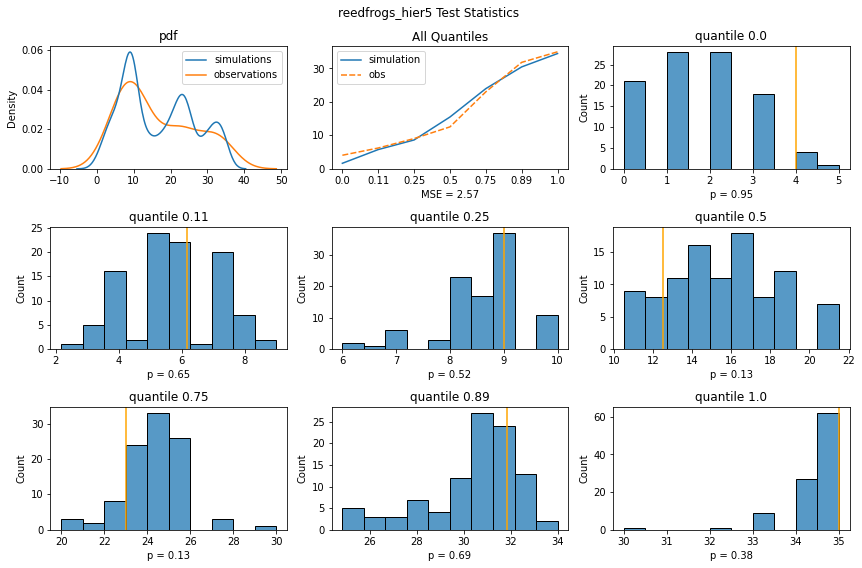

In [111]:
observations = df.surv
simulator = lambda: simulate_hier5(df)
plot_check(observations, simulator, "reedfrogs_hier5 Test Statistics")

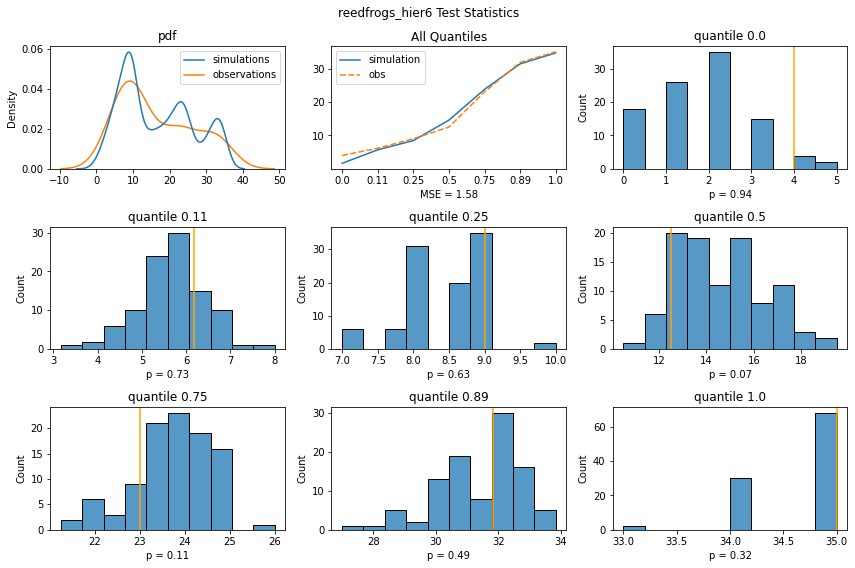

In [112]:
observations = df.surv
simulator = lambda: simulate_hier6(df)
plot_check(observations, simulator, "reedfrogs_hier6 Test Statistics")

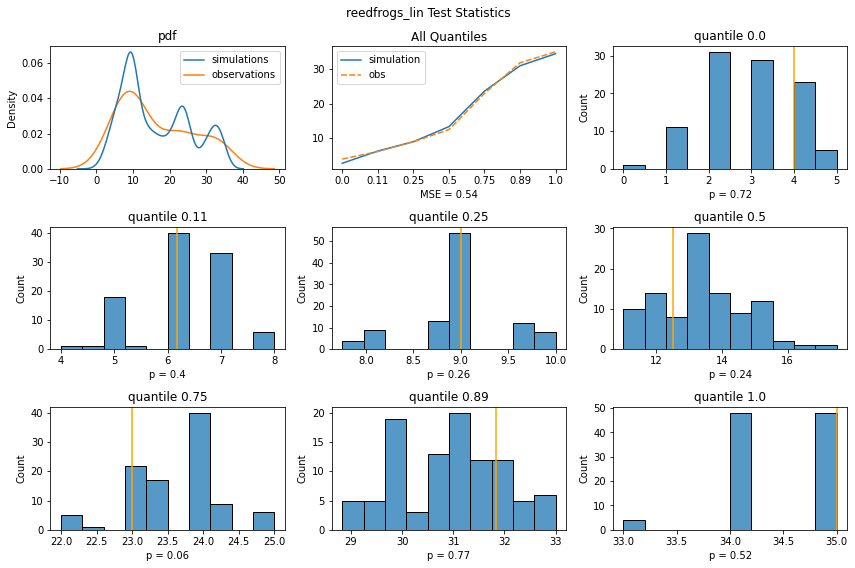

In [118]:
observations = df.surv
simulator = lambda: simulate_lin(df)
plot_check(observations, simulator, "reedfrogs_lin Test Statistics")

## Evaluating the Models